## 8.定义卷积神经网络（CNN）

查看正在使用的数据之后，了解图像与关键点的形状，接下来，就可以定义一个机器人可以从这些数据中 *学习*的卷积神经网络。

在这个notebook和`models.py`中，你的任务是：
1. 定义一个CNN，把图像作为输入，把关键点作为输出
2. 与以前一样，构造转换后的FaceKeypointsDataset
3. 使用训练数据训练这个CNN，并跟踪损失
4. 查看训练模型对测试数据的执行情况
5. 如有必要，请修改CNN结构并模拟超参数，使其*表现良好* **\***

**\***  什么是*表现良好*？

“表现良好”意味着该模型的损失在训练期间有所降低，**而且**该模型应用于测试图像数据时，会产生与每个人脸的真实关键点紧密匹配的关键点。你会在这个notebook中看到这个例子。

---

## 9.CNN架构

回想一下，CNN是由下列几种类型的层定义的：
* 卷积层
* 最大池化层
* 全连接层

你需要使用上述层，而且我们建议你添加多个卷积层以及防止过度拟合的dropout层等。此外，你还可以查看一些有关关键点检测的文献，如 [这篇论文](https://arxiv.org/pdf/1710.00977.pdf)，帮助你确定该网络的结构。


### TODO: 在`models.py`文件中定义你的模型

此文件大部分为空，但其中包含预期的名称和一些用于创建模型的TODO事项。

---

## 10.PyTorch神经网络

要在PyTorch中定义神经网络，你可以在函数`__init__`中定义一个模型的各个层，并定义一个网络的前馈行为，该网络会在函数`forward`中使用这些初始化的层，而该函数会接收输入图像张量`x`。此Net类的结构如下所示，并由你来填充。

注意：在训练期间，PyTorch能够通过跟踪网络的前馈行为并使用autograd来计算该网络中权重的更新来执行反向传播。

#### 在` __init__`中定义层
提醒一下，卷积层与池化层可以像这样来定义（在`__init__`中）：

In [ ]:
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)
# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      

#### 引用`forward`中的层
然后在这样的`forward`函数中引用，其中卷积1层在应用最大池化之前应用了ReLu激活函数：

In [ ]:
x = self.pool(F.relu(self.conv1(x)))

最佳做法是把权重将在训练过程中发生变化的任何层防治在`__init__`中，并在`forward`函数中引用它们。所有始终以相同方式运行的层或函数（例如预定义的激活函数）应*只* 出现在`forward` 函数中。

#### 为什么要用models.py文件

你的任务是在`models.py`文件中定义该网络，便于在此项目目录中的不同notebook中按名称保存和加载你定义的任何模型。例如，通过在`models.py`中定义名为`Net`的CNN类，通过简单地导入该类并实例化模型，就可以在此notebook和其他notebook中创建相同的体系结构：

In [ ]:
from models import Net
net = Net()

In [ ]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

<div class="alert alert-info">**注意：**工作区会在持续30分钟的不活动状态后，自动关闭连接，包括训练时出现不活动状态。使用下面的代码段可以在训练期间保持工作区的活动状态。下面导入了active_session上下文管理器。
</div>

In [ ]:
from workspace_utils import active_session
with active_session():
    train_model(num_epochs)

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np
# import utilities to keep workspaces alive during model training
from workspace_utils import active_session
# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
## TODO: Define the Net in models.py
import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it.
# One example conv layer has been provided for you.
from models import Net
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop5): Dropout(p=0.5)
  (drop6): Dropout(p=0.6)
  (fc1): Linear(in_features=36864, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
)


## 转换数据集 

为训练做准备，你还需要创建一个图像和关键点的转换数据集。

### TODO: 定义一个数据转换

在PyTorch中，卷积神经网络需要一个大小一致的torch图像作为输入。为了进行有效的训练，以及在训练过程中该模型的损失不会放大，我们还建议你对输入图像和关键点进行归一化。必要的转换已在`data_load.py`中定义，你无需再做修改。另外，你可以看一下这个文件，你会在该文件中看到Notebook 1中定义和应用的相同转换。

要定义下面的数据转换，请使用以下[组合](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) ：
1. 重新缩放和/或裁剪数据，最终需要一个方形图像（建议大小为224x224px）
2. 归一化图像和关键点；将每个RGB图像转换为颜色范围为[0,1]的灰度图像，并将给定关键点转换为[-1,1]的范围
3. 将这些图像和关键点转换为张量

这些转换已在`data_load.py`中定义，但是否要在下面调用它们并创建一个`data_transform`，这都取决于你。**该转换将应用于训练数据，以及稍后的测试数据**。这样将改变显示这些图像和关键点的方式，但这些步骤对于高效训练来说非常重要。

需要说明的一点是，如果你想要执行数据增强（在此项目中是可选的），并随机旋转或移动这些图像，方形图像大小将会很有用，将224x224图像旋转90度就会产生相同的输出形状。

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor

## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
# data_transform = None
data_transform = transforms.Compose([Rescale(250), RandomCrop(224), Normalize(), ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [4]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/', transform=data_transform)

print('Number of images: ', len(transformed_dataset))
# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## 批处理并加载数据

定义了转换数据集之后，接下来，我们可以使用PyTorch的DataLoader类来批量加载任意大小的训练数据，也可以对训练模型的数据进行置乱处理。你可以在 [本文档](http://pytorch.org/docs/master/data.html)中阅读有关DataLoader参数的更多信息。

#### 批量大小
确定用于训练模型的最合适的批量是多少。小批量与大批量都要试一试，并注意在模型训练时损失会如何减少。批量过大可能会导致模型在训练时崩溃和/或内存不足。

**Windows用户需要注意：**请将`num_workers`改为0，否则可能会遇到DataLoader失效的问题。

In [5]:
# load training data in batches
batch_size = 10
train_loader = DataLoader(transformed_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

## 训练之前

看一下这个模型在训练之前的表现。你应该会看到，它预测的关键点从一个点开始，并且与人脸上的关键点根本不匹配！你可以把此行为可视化，并在训练后将其与模型进行比较，还可以查看该模型是如何改进的。

#### 加载测试数据集

此模型之前*没有*见过这个测试数据集，这就是说，它没有使用这些图像进行过训练。在这里，我们将加载此测试数据，并在训练前后，查看你的模型在此数据集上的表现效果如何！

为了可视化这些测试数据，我们必须要做一些非转换步骤，将图像转换为张量的python图像，并将关键点重新转换回可识别的范围。

In [6]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above
# Create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                    root_dir='/data/test/', transform=data_transform)

In [7]:
# load test data in batches
batch_size = 10
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

## 将模型应用于测试样本

要在测试数据样本上测试模型，你必须执行以下步骤：
1. 从样本中提取图像和实际真值关键点
2. 将图像隐藏在变量中，便于你的网络将其作为输入处理，并跟踪图像在该网络中移动时发生的变化。
3. 确保图像是模型所需的FloatTensor。
4. 通过网络向前传递图像，获得预测的输出关键点。

此函数测试的是该网络在第一批测试数据上的执行情况。它会返回图像、转换图像、预测由模型产生的关键点以及实际真值关键点。

In [8]:
# Test the model on a batch of test images;
def net_sample_output():    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']
        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        # forward pass to get net output
        output_pts = net(images)
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

#### 调试技巧

如果此处出现尺寸或维度错误，请确保你的网络输出预期数量的关键点！或者，如果收到Tensor类型的错误，请考虑将数据转换为float类型的上述代码进行更改，float类型为：`images = images.type(torch.FloatTensor)`。

In [9]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()
# Print out the dimensions of the data to see if they make sense.
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## 将预测的关键点可视化

让模型生成一些预测的输出关键点之后，就可以用一种类似于我们之前显示这些数据的方式来显示这些点，只是这一次，要显示这些点，我们必须“取消转换”图像/关键点数据。

请注意，我已经定义了一个*新*函数`show_all_keypoints`，它会显示灰度图像、其预测的关键点以及其实际真值关键点（如果提供的话）。

In [10]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

#### 非转换

接下来，你会看到一个辅助函数，即`visualize_output`，它会接收一批图像、预测关键点以及实际真值关键点，并显示一组图像及其真实/预测关键点。

此函数的主要作用是获取批量图像和关键点数据（CNN的输入和输出），并将它们转换为numpy图像和非归一化关键点（x，y），从而进行正常显示。非转换过程将关键点和图像转换为来自Tensors的numpy数组，*此外*， 它撤消了Normalize（）转换中完成的关键点归一化。但前提是我们假设，你在载测试数据时应用了这些转换。

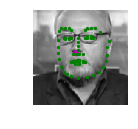

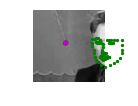

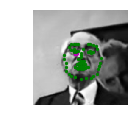

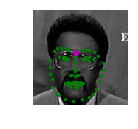

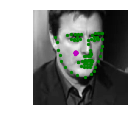

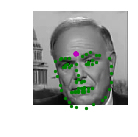

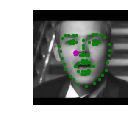

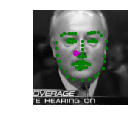

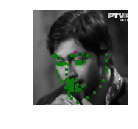

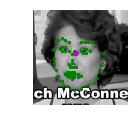

In [11]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image
        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
        plt.axis('off')
    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## 训练

#### 损失函数
训练一个用于预测关键点的网络与训练一个用于预测类的网络不同。你可能希望选择适合回归的损失函数，而不是输出类的分布并使用交交叉熵损失函数，因为损失函数可以用于直接比较预测值和目标值。有关各种损失函数（如MSE或L1 / SmoothL1损失），请阅读 [本文档](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html)中的内容。

### TODO: 定义损失与优化

接下来，你需要通过定义损失函数和优化程序来定义模型的训练方式。

---

In [12]:
## TODO: Define the loss and optimization
import torch.optim as optim
criterion = nn.MSELoss() # None
optimizer = optim.Adam(params = net.parameters(), lr = 0.001) # None

## 训练与初步观察

现在，你要使用大量epoch，从`train_loader`中训练你的批量训练数据。

为了快速观察你的模型是如何训练并决定是否应该修改它的结构或超参数，我们建议你最开始的时候使用一个或两个epoch。训练时，请注意观察模型的损失会如何随着时间的推移而变化：例如，它会先快速减少然后再减慢吗？或者起初会在一段时间后出现减少？如果更改了训练数据的批量大小或修改损失函数，会发生什么变化？

在使用多个epoch进行训练并创建最终模型之前，使用这些初始观察值对模型进行更改并确定一个最佳架构。

In [38]:
def train_net(n_epochs):
    # prepare the net for training
    net.train()
    print(time.strftime('%Y-%m-%d %H:%M:%S GMT-0',time.localtime(time.time())))
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)
            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            # forward pass to get outputs
            output_pts = net(images)
            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)
            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            # backward pass to calculate the weight gradients
            loss.backward()
            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 20 == 19:    # print every 10/40/20 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0
        print(time.strftime('%Y-%m-%d %H:%M:%S GMT-0',time.localtime(time.time())))

    print('Finished Training.')

In [37]:
print(time.strftime('%Y-%m-%d %H:%M:%S GMT-0',time.localtime(time.time())))

2019-03-31 14:49:22 GMT-0


In [39]:
print(time.strftime('%Y-%m-%d %H:%M:%S GMT-0',time.localtime(time.time())))
# train your network
# start small, and increase when you've decided on your model structure and hyperparams
n_epochs = 35    # Training takes long time, use value 1 for test/try, before: value 3;
# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_6_EPOCH-35.pt'    # 'keypoints_model_1.pt'
# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)
print('Finished Saving The Model.')
print(time.strftime('%Y-%m-%d %H:%M:%S GMT-0',time.localtime(time.time())))

2019-03-31 14:59:38 GMT-0
2019-03-31 14:59:38 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 20, Avg. Loss: 0.11044750027358533
Epoch: 1, Batch: 40, Avg. Loss: 0.15603368747979401
Epoch: 1, Batch: 60, Avg. Loss: 0.11563016548752784
Epoch: 1, Batch: 80, Avg. Loss: 0.0987872201949358
Epoch: 1, Batch: 100, Avg. Loss: 0.10915477219969034
Epoch: 1, Batch: 120, Avg. Loss: 0.3141704384237528
Epoch: 1, Batch: 140, Avg. Loss: 0.10321475751698017
Epoch: 1, Batch: 160, Avg. Loss: 0.13394779302179813
Epoch: 1, Batch: 180, Avg. Loss: 0.11491177920252085
Epoch: 1, Batch: 200, Avg. Loss: 0.16896036751568316
Epoch: 1, Batch: 220, Avg. Loss: 0.10678050760179758
Epoch: 1, Batch: 240, Avg. Loss: 0.1373412234708667
Epoch: 1, Batch: 260, Avg. Loss: 0.1232292665168643
Epoch: 1, Batch: 280, Avg. Loss: 0.13320785723626613
Epoch: 1, Batch: 300, Avg. Loss: 0.10117825772613287
Epoch: 1, Batch: 320, Avg. Loss: 0.15828761979937553
Epoch: 1, Batch: 340, Avg. Loss: 0.13371521141380072
2019-03-31 15:14:28 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 20, Avg. Loss: 0.13115669190883636
Epoch: 2, Batch: 40, Avg. Loss: 0.09105119500309229
Epoch: 2, Batch: 60, Avg. Loss: 0.29805874936282634
Epoch: 2, Batch: 80, Avg. Loss: 0.10975797139108182
Epoch: 2, Batch: 100, Avg. Loss: 0.13057811204344033
Epoch: 2, Batch: 120, Avg. Loss: 0.11965005472302437
Epoch: 2, Batch: 140, Avg. Loss: 0.10325516853481531
Epoch: 2, Batch: 160, Avg. Loss: 0.17669795118272305
Epoch: 2, Batch: 180, Avg. Loss: 0.1093354219570756
Epoch: 2, Batch: 200, Avg. Loss: 0.13508769907057286
Epoch: 2, Batch: 220, Avg. Loss: 0.11927724722772837
Epoch: 2, Batch: 240, Avg. Loss: 0.13007704652845858
Epoch: 2, Batch: 260, Avg. Loss: 0.11923049911856651
Epoch: 2, Batch: 280, Avg. Loss: 0.1699763935059309
Epoch: 2, Batch: 300, Avg. Loss: 0.11334604173898696
Epoch: 2, Batch: 320, Avg. Loss: 0.09379554204642773
Epoch: 2, Batch: 340, Avg. Loss: 0.12938485480844975
2019-03-31 15:29:21 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 20, Avg. Loss: 0.15725525487214326
Epoch: 3, Batch: 40, Avg. Loss: 0.12209252659231425
Epoch: 3, Batch: 60, Avg. Loss: 0.10466132573783397
Epoch: 3, Batch: 80, Avg. Loss: 0.10039791353046894
Epoch: 3, Batch: 100, Avg. Loss: 0.10986425280570984
Epoch: 3, Batch: 120, Avg. Loss: 0.10113630536943674
Epoch: 3, Batch: 140, Avg. Loss: 0.19375804532319307
Epoch: 3, Batch: 160, Avg. Loss: 0.13333396352827548
Epoch: 3, Batch: 180, Avg. Loss: 0.2131282638758421
Epoch: 3, Batch: 200, Avg. Loss: 0.1576975764706731
Epoch: 3, Batch: 220, Avg. Loss: 0.0994695832952857
Epoch: 3, Batch: 240, Avg. Loss: 0.10240570921450853
Epoch: 3, Batch: 260, Avg. Loss: 0.09821922164410353
Epoch: 3, Batch: 280, Avg. Loss: 0.1397960152477026
Epoch: 3, Batch: 300, Avg. Loss: 0.10101810414344073
Epoch: 3, Batch: 320, Avg. Loss: 0.09756624680012464
Epoch: 3, Batch: 340, Avg. Loss: 0.13184881079941987
2019-03-31 15:44:07 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 20, Avg. Loss: 0.13512285947799682
Epoch: 4, Batch: 40, Avg. Loss: 0.1271757697686553
Epoch: 4, Batch: 60, Avg. Loss: 0.09596623182296753
Epoch: 4, Batch: 80, Avg. Loss: 0.11067891009151935
Epoch: 4, Batch: 100, Avg. Loss: 0.10755175910890102
Epoch: 4, Batch: 120, Avg. Loss: 0.13254774026572705
Epoch: 4, Batch: 140, Avg. Loss: 0.11861917395144701
Epoch: 4, Batch: 160, Avg. Loss: 0.09592562355101109
Epoch: 4, Batch: 180, Avg. Loss: 0.11785555444657803
Epoch: 4, Batch: 200, Avg. Loss: 0.11453765481710435
Epoch: 4, Batch: 220, Avg. Loss: 0.10355754885822535
Epoch: 4, Batch: 240, Avg. Loss: 0.12126254476606846
Epoch: 4, Batch: 260, Avg. Loss: 0.09118622113019229
Epoch: 4, Batch: 280, Avg. Loss: 0.09222494717687368
Epoch: 4, Batch: 300, Avg. Loss: 0.11882576588541269
Epoch: 4, Batch: 320, Avg. Loss: 0.10267970040440559
Epoch: 4, Batch: 340, Avg. Loss: 0.10775134731084109
2019-03-31 15:58:57 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 20, Avg. Loss: 0.09432848002761603
Epoch: 5, Batch: 40, Avg. Loss: 0.12928868383169173
Epoch: 5, Batch: 60, Avg. Loss: 0.17755791023373604
Epoch: 5, Batch: 80, Avg. Loss: 0.1554961394518614
Epoch: 5, Batch: 100, Avg. Loss: 0.11040587071329355
Epoch: 5, Batch: 120, Avg. Loss: 0.1008882138878107
Epoch: 5, Batch: 140, Avg. Loss: 0.12859023697674274
Epoch: 5, Batch: 160, Avg. Loss: 0.09573222901672125
Epoch: 5, Batch: 180, Avg. Loss: 0.0945886604487896
Epoch: 5, Batch: 200, Avg. Loss: 0.10597627311944961
Epoch: 5, Batch: 220, Avg. Loss: 0.10093734133988619
Epoch: 5, Batch: 240, Avg. Loss: 0.11568552367389202
Epoch: 5, Batch: 260, Avg. Loss: 0.09087466467171908
Epoch: 5, Batch: 280, Avg. Loss: 0.09231749214231968
Epoch: 5, Batch: 300, Avg. Loss: 0.09188764542341232
Epoch: 5, Batch: 320, Avg. Loss: 0.1247517017647624
Epoch: 5, Batch: 340, Avg. Loss: 0.08734699431806803
2019-03-31 16:13:32 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 20, Avg. Loss: 0.16447564419358968
Epoch: 6, Batch: 40, Avg. Loss: 0.1347391616553068
Epoch: 6, Batch: 60, Avg. Loss: 0.08747114967554807
Epoch: 6, Batch: 80, Avg. Loss: 0.10625524129718542
Epoch: 6, Batch: 100, Avg. Loss: 0.10876444242894649
Epoch: 6, Batch: 120, Avg. Loss: 0.10379004422575236
Epoch: 6, Batch: 140, Avg. Loss: 0.09465416483581066
Epoch: 6, Batch: 160, Avg. Loss: 0.13058677669614555
Epoch: 6, Batch: 180, Avg. Loss: 0.11893379073590041
Epoch: 6, Batch: 200, Avg. Loss: 0.09143200926482678
Epoch: 6, Batch: 220, Avg. Loss: 0.10326940640807152
Epoch: 6, Batch: 240, Avg. Loss: 0.2895031297579408
Epoch: 6, Batch: 260, Avg. Loss: 0.10098237860947848
Epoch: 6, Batch: 280, Avg. Loss: 0.11713239140808582
Epoch: 6, Batch: 300, Avg. Loss: 0.0857945354655385
Epoch: 6, Batch: 320, Avg. Loss: 0.14446545597165822
Epoch: 6, Batch: 340, Avg. Loss: 0.11707267109304667
2019-03-31 16:28:12 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 20, Avg. Loss: 0.15469909012317656
Epoch: 7, Batch: 40, Avg. Loss: 0.1784250807017088
Epoch: 7, Batch: 60, Avg. Loss: 0.14812205601483583
Epoch: 7, Batch: 80, Avg. Loss: 0.12816140800714493
Epoch: 7, Batch: 100, Avg. Loss: 0.17537213992327452
Epoch: 7, Batch: 120, Avg. Loss: 0.14449055418372153
Epoch: 7, Batch: 140, Avg. Loss: 0.16622888557612897
Epoch: 7, Batch: 160, Avg. Loss: 0.12310972549021244
Epoch: 7, Batch: 180, Avg. Loss: 0.10766997113823891
Epoch: 7, Batch: 200, Avg. Loss: 0.09409121852368116
Epoch: 7, Batch: 220, Avg. Loss: 0.1768990870565176
Epoch: 7, Batch: 240, Avg. Loss: 0.11596900634467602
Epoch: 7, Batch: 260, Avg. Loss: 0.105169571749866
Epoch: 7, Batch: 280, Avg. Loss: 0.10500036161392927
Epoch: 7, Batch: 300, Avg. Loss: 0.08073101602494717
Epoch: 7, Batch: 320, Avg. Loss: 0.0815670358017087
Epoch: 7, Batch: 340, Avg. Loss: 0.15536586213856934
2019-03-31 16:42:54 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 20, Avg. Loss: 0.0938178924843669
Epoch: 8, Batch: 40, Avg. Loss: 0.1120320625603199
Epoch: 8, Batch: 60, Avg. Loss: 0.18148648012429475
Epoch: 8, Batch: 80, Avg. Loss: 0.13130109552294017
Epoch: 8, Batch: 100, Avg. Loss: 0.09684250224381685
Epoch: 8, Batch: 120, Avg. Loss: 0.09803444780409336
Epoch: 8, Batch: 140, Avg. Loss: 0.10960229206830263
Epoch: 8, Batch: 160, Avg. Loss: 0.0934980869293213
Epoch: 8, Batch: 180, Avg. Loss: 0.09696157574653626
Epoch: 8, Batch: 200, Avg. Loss: 0.12491840198636055
Epoch: 8, Batch: 220, Avg. Loss: 0.11267840210348368
Epoch: 8, Batch: 240, Avg. Loss: 0.13229553792625665
Epoch: 8, Batch: 260, Avg. Loss: 0.1504089217633009
Epoch: 8, Batch: 280, Avg. Loss: 0.11399352755397558
Epoch: 8, Batch: 300, Avg. Loss: 0.11212246417999268
Epoch: 8, Batch: 320, Avg. Loss: 0.14363752081990241
Epoch: 8, Batch: 340, Avg. Loss: 0.11024674251675606
2019-03-31 16:57:44 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 20, Avg. Loss: 0.110407305508852
Epoch: 9, Batch: 40, Avg. Loss: 0.08307927437126636
Epoch: 9, Batch: 60, Avg. Loss: 0.08954719435423612
Epoch: 9, Batch: 80, Avg. Loss: 0.09738424196839332
Epoch: 9, Batch: 100, Avg. Loss: 0.09048608709126711
Epoch: 9, Batch: 120, Avg. Loss: 0.1358660850673914
Epoch: 9, Batch: 140, Avg. Loss: 0.11421244442462922
Epoch: 9, Batch: 160, Avg. Loss: 0.12871263828128576
Epoch: 9, Batch: 180, Avg. Loss: 0.09871591199189425
Epoch: 9, Batch: 200, Avg. Loss: 0.11012746207416058
Epoch: 9, Batch: 220, Avg. Loss: 0.11534277517348528
Epoch: 9, Batch: 240, Avg. Loss: 0.1820252088829875
Epoch: 9, Batch: 260, Avg. Loss: 0.09125630892813205
Epoch: 9, Batch: 280, Avg. Loss: 0.09851251281797886
Epoch: 9, Batch: 300, Avg. Loss: 0.08720614518970252
Epoch: 9, Batch: 320, Avg. Loss: 0.1250545982271433
Epoch: 9, Batch: 340, Avg. Loss: 0.09290781617164612
2019-03-31 17:12:20 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 20, Avg. Loss: 0.0813844796270132
Epoch: 10, Batch: 40, Avg. Loss: 0.07840031124651432
Epoch: 10, Batch: 60, Avg. Loss: 0.09808465465903282
Epoch: 10, Batch: 80, Avg. Loss: 0.11991344708949328
Epoch: 10, Batch: 100, Avg. Loss: 0.08317310810089111
Epoch: 10, Batch: 120, Avg. Loss: 0.0805665161460638
Epoch: 10, Batch: 140, Avg. Loss: 0.12059778906404972
Epoch: 10, Batch: 160, Avg. Loss: 0.07732396628707647
Epoch: 10, Batch: 180, Avg. Loss: 0.10028344672173262
Epoch: 10, Batch: 200, Avg. Loss: 0.09040570110082627
Epoch: 10, Batch: 220, Avg. Loss: 0.12596939504146576
Epoch: 10, Batch: 240, Avg. Loss: 0.12983694802969695
Epoch: 10, Batch: 260, Avg. Loss: 0.1461650835350156
Epoch: 10, Batch: 280, Avg. Loss: 0.13217488806694747
Epoch: 10, Batch: 300, Avg. Loss: 0.11019949987530708
Epoch: 10, Batch: 320, Avg. Loss: 0.09871333613991737
Epoch: 10, Batch: 340, Avg. Loss: 0.1444124285131693
2019-03-31 17:26:58 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 20, Avg. Loss: 0.09229202587157488
Epoch: 11, Batch: 40, Avg. Loss: 0.08058162517845631
Epoch: 11, Batch: 60, Avg. Loss: 0.08702568151056767
Epoch: 11, Batch: 80, Avg. Loss: 0.09370165467262268
Epoch: 11, Batch: 100, Avg. Loss: 0.08495632279664278
Epoch: 11, Batch: 120, Avg. Loss: 0.17596347760409117
Epoch: 11, Batch: 140, Avg. Loss: 0.09361403118818998
Epoch: 11, Batch: 160, Avg. Loss: 0.10173792168498039
Epoch: 11, Batch: 180, Avg. Loss: 0.11269604824483395
Epoch: 11, Batch: 200, Avg. Loss: 0.12886258512735366
Epoch: 11, Batch: 220, Avg. Loss: 0.16113361679017543
Epoch: 11, Batch: 240, Avg. Loss: 0.10694297924637794
Epoch: 11, Batch: 260, Avg. Loss: 0.08817176036536693
Epoch: 11, Batch: 280, Avg. Loss: 0.10398584734648467
Epoch: 11, Batch: 300, Avg. Loss: 0.09375702273100614
Epoch: 11, Batch: 320, Avg. Loss: 0.08298761527985335
Epoch: 11, Batch: 340, Avg. Loss: 0.09648752436041833
2019-03-31 17:41:40 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 20, Avg. Loss: 0.08186942636966706
Epoch: 12, Batch: 40, Avg. Loss: 0.08703821040689945
Epoch: 12, Batch: 60, Avg. Loss: 0.10025840699672699
Epoch: 12, Batch: 80, Avg. Loss: 0.08219812475144864
Epoch: 12, Batch: 100, Avg. Loss: 0.08634591531008481
Epoch: 12, Batch: 120, Avg. Loss: 0.10554422196000815
Epoch: 12, Batch: 140, Avg. Loss: 0.1252396445721388
Epoch: 12, Batch: 160, Avg. Loss: 0.10812835581600666
Epoch: 12, Batch: 180, Avg. Loss: 0.12974730022251607
Epoch: 12, Batch: 200, Avg. Loss: 0.08884332198649644
Epoch: 12, Batch: 220, Avg. Loss: 0.08642858453094959
Epoch: 12, Batch: 240, Avg. Loss: 0.09376341663300991
Epoch: 12, Batch: 260, Avg. Loss: 0.10308801531791686
Epoch: 12, Batch: 280, Avg. Loss: 0.0794315304607153
Epoch: 12, Batch: 300, Avg. Loss: 0.11238505486398935
Epoch: 12, Batch: 320, Avg. Loss: 0.17152701411396265
Epoch: 12, Batch: 340, Avg. Loss: 0.17802087869495153
2019-03-31 17:56:46 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 20, Avg. Loss: 0.11042261961847544
Epoch: 13, Batch: 40, Avg. Loss: 0.16349544636905194
Epoch: 13, Batch: 60, Avg. Loss: 0.11890180706977845
Epoch: 13, Batch: 80, Avg. Loss: 0.09277623519301414
Epoch: 13, Batch: 100, Avg. Loss: 0.10672078803181648
Epoch: 13, Batch: 120, Avg. Loss: 0.08670956771820784
Epoch: 13, Batch: 140, Avg. Loss: 0.09243386369198561
Epoch: 13, Batch: 160, Avg. Loss: 0.0810079975053668
Epoch: 13, Batch: 180, Avg. Loss: 0.09935489725321531
Epoch: 13, Batch: 200, Avg. Loss: 0.09803828690201044
Epoch: 13, Batch: 220, Avg. Loss: 0.08766165189445019
Epoch: 13, Batch: 240, Avg. Loss: 0.07532777097076178
Epoch: 13, Batch: 260, Avg. Loss: 0.319414396956563
Epoch: 13, Batch: 280, Avg. Loss: 0.24995504282414913
Epoch: 13, Batch: 300, Avg. Loss: 0.12261546719819308
Epoch: 13, Batch: 320, Avg. Loss: 0.06486949529498816
Epoch: 13, Batch: 340, Avg. Loss: 0.0966947527602315
2019-03-31 18:11:39 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 20, Avg. Loss: 0.07835102044045925
Epoch: 14, Batch: 40, Avg. Loss: 0.08314129877835512
Epoch: 14, Batch: 60, Avg. Loss: 0.08758973367512227
Epoch: 14, Batch: 80, Avg. Loss: 0.2314993619918823
Epoch: 14, Batch: 100, Avg. Loss: 0.16741969157010317
Epoch: 14, Batch: 120, Avg. Loss: 0.13108656778931618
Epoch: 14, Batch: 140, Avg. Loss: 0.11041964404284954
Epoch: 14, Batch: 160, Avg. Loss: 0.08954168278723955
Epoch: 14, Batch: 180, Avg. Loss: 0.12431461922824383
Epoch: 14, Batch: 200, Avg. Loss: 0.08512352537363768
Epoch: 14, Batch: 220, Avg. Loss: 0.16971812006086112
Epoch: 14, Batch: 240, Avg. Loss: 0.09371924977749586
Epoch: 14, Batch: 260, Avg. Loss: 0.09518309868872166
Epoch: 14, Batch: 280, Avg. Loss: 0.13194348607212306
Epoch: 14, Batch: 300, Avg. Loss: 0.08195834830403328
Epoch: 14, Batch: 320, Avg. Loss: 0.08490420524030924
Epoch: 14, Batch: 340, Avg. Loss: 0.09813342522829771
2019-03-31 18:26:22 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 20, Avg. Loss: 0.11608867440372705
Epoch: 15, Batch: 40, Avg. Loss: 0.0840458208695054
Epoch: 15, Batch: 60, Avg. Loss: 0.08138867709785699
Epoch: 15, Batch: 80, Avg. Loss: 0.08401449304074049
Epoch: 15, Batch: 100, Avg. Loss: 0.09021215196698903
Epoch: 15, Batch: 120, Avg. Loss: 0.1224384294822812
Epoch: 15, Batch: 140, Avg. Loss: 0.3057843120768666
Epoch: 15, Batch: 160, Avg. Loss: 0.16472698524594306
Epoch: 15, Batch: 180, Avg. Loss: 0.11110004968941212
Epoch: 15, Batch: 200, Avg. Loss: 0.13134843800216914
Epoch: 15, Batch: 220, Avg. Loss: 0.15377854984253644
Epoch: 15, Batch: 240, Avg. Loss: 0.10582378040999174
Epoch: 15, Batch: 260, Avg. Loss: 0.08901519346982241
Epoch: 15, Batch: 280, Avg. Loss: 0.13082756623625755
Epoch: 15, Batch: 300, Avg. Loss: 0.09690516833215952
Epoch: 15, Batch: 320, Avg. Loss: 0.09477980230003595
Epoch: 15, Batch: 340, Avg. Loss: 0.10914341472089291
2019-03-31 18:41:30 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 16, Batch: 20, Avg. Loss: 0.12642190512269735
Epoch: 16, Batch: 40, Avg. Loss: 0.09190878458321095
Epoch: 16, Batch: 60, Avg. Loss: 0.0860120166093111
Epoch: 16, Batch: 80, Avg. Loss: 0.11319814193993807
Epoch: 16, Batch: 100, Avg. Loss: 0.11837956905364991
Epoch: 16, Batch: 120, Avg. Loss: 0.16266747042536736
Epoch: 16, Batch: 140, Avg. Loss: 0.10713108405470848
Epoch: 16, Batch: 160, Avg. Loss: 0.10597527381032705
Epoch: 16, Batch: 180, Avg. Loss: 0.14059626795351504
Epoch: 16, Batch: 200, Avg. Loss: 0.10092077776789665
Epoch: 16, Batch: 220, Avg. Loss: 0.092485074326396
Epoch: 16, Batch: 240, Avg. Loss: 0.0863235630095005
Epoch: 16, Batch: 260, Avg. Loss: 0.0908083613961935
Epoch: 16, Batch: 280, Avg. Loss: 0.0942886870354414
Epoch: 16, Batch: 300, Avg. Loss: 0.08113864846527577
Epoch: 16, Batch: 320, Avg. Loss: 0.10185829252004623
Epoch: 16, Batch: 340, Avg. Loss: 0.09646638501435519
2019-03-31 18:57:20 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 17, Batch: 20, Avg. Loss: 0.08841287102550269
Epoch: 17, Batch: 40, Avg. Loss: 0.07766015119850636
Epoch: 17, Batch: 60, Avg. Loss: 0.0686148414388299
Epoch: 17, Batch: 80, Avg. Loss: 0.12816627845168113
Epoch: 17, Batch: 100, Avg. Loss: 0.09332615286111831
Epoch: 17, Batch: 120, Avg. Loss: 0.0791508411988616
Epoch: 17, Batch: 140, Avg. Loss: 0.08288462199270726
Epoch: 17, Batch: 160, Avg. Loss: 0.08870986681431532
Epoch: 17, Batch: 180, Avg. Loss: 0.1547102902084589
Epoch: 17, Batch: 200, Avg. Loss: 0.1103797672316432
Epoch: 17, Batch: 220, Avg. Loss: 0.09195994883775711
Epoch: 17, Batch: 240, Avg. Loss: 0.11988664735108615
Epoch: 17, Batch: 260, Avg. Loss: 0.08412936013191938
Epoch: 17, Batch: 280, Avg. Loss: 0.09795623235404491
Epoch: 17, Batch: 300, Avg. Loss: 0.07663942631334067
Epoch: 17, Batch: 320, Avg. Loss: 0.0925266269594431
Epoch: 17, Batch: 340, Avg. Loss: 0.07547126282006503
2019-03-31 19:12:48 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 18, Batch: 20, Avg. Loss: 0.08238528855144978
Epoch: 18, Batch: 40, Avg. Loss: 0.08304242510348558
Epoch: 18, Batch: 60, Avg. Loss: 0.11215106397867203
Epoch: 18, Batch: 80, Avg. Loss: 0.07301131449639797
Epoch: 18, Batch: 100, Avg. Loss: 0.08052983414381742
Epoch: 18, Batch: 120, Avg. Loss: 0.08796057067811489
Epoch: 18, Batch: 140, Avg. Loss: 0.08414357099682093
Epoch: 18, Batch: 180, Avg. Loss: 0.0959617905318737
Epoch: 18, Batch: 200, Avg. Loss: 0.08664351981133223
Epoch: 18, Batch: 220, Avg. Loss: 0.08020077962428332
Epoch: 18, Batch: 240, Avg. Loss: 0.15104716867208481
Epoch: 18, Batch: 260, Avg. Loss: 0.09250761903822421
Epoch: 18, Batch: 280, Avg. Loss: 0.08741750568151474
Epoch: 18, Batch: 300, Avg. Loss: 0.08314307387918234
Epoch: 18, Batch: 320, Avg. Loss: 0.08174261096864939
Epoch: 18, Batch: 340, Avg. Loss: 0.11609141323715448
2019-03-31 19:27:36 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 19, Batch: 20, Avg. Loss: 0.07849121559411287
Epoch: 19, Batch: 40, Avg. Loss: 0.08869120422750712
Epoch: 19, Batch: 60, Avg. Loss: 0.07888388764113188
Epoch: 19, Batch: 80, Avg. Loss: 0.1501115769147873
Epoch: 19, Batch: 100, Avg. Loss: 0.10320472456514836
Epoch: 19, Batch: 120, Avg. Loss: 0.09369843825697899
Epoch: 19, Batch: 140, Avg. Loss: 0.08430156391113997
Epoch: 19, Batch: 160, Avg. Loss: 0.10473157279193401
Epoch: 19, Batch: 180, Avg. Loss: 0.08863960299640894
Epoch: 19, Batch: 200, Avg. Loss: 0.09041787050664425
Epoch: 19, Batch: 220, Avg. Loss: 0.09123984668403864
Epoch: 19, Batch: 240, Avg. Loss: 0.0753625262528658
Epoch: 19, Batch: 260, Avg. Loss: 0.0790789246559143
Epoch: 19, Batch: 280, Avg. Loss: 0.08091496741399169
Epoch: 19, Batch: 300, Avg. Loss: 0.08343542311340571
Epoch: 19, Batch: 320, Avg. Loss: 0.1216946279630065
Epoch: 19, Batch: 340, Avg. Loss: 0.09190485589206218
2019-03-31 19:42:19 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 20, Batch: 20, Avg. Loss: 0.0774459708482027
Epoch: 20, Batch: 40, Avg. Loss: 0.1126109117642045
Epoch: 20, Batch: 60, Avg. Loss: 0.08034724444150924
Epoch: 20, Batch: 80, Avg. Loss: 0.08842842262238264
Epoch: 20, Batch: 100, Avg. Loss: 0.07474814895540476
Epoch: 20, Batch: 120, Avg. Loss: 0.27524268738925456
Epoch: 20, Batch: 140, Avg. Loss: 0.11922309659421444
Epoch: 20, Batch: 160, Avg. Loss: 0.13047995306551458
Epoch: 20, Batch: 180, Avg. Loss: 0.11716214381158352
Epoch: 20, Batch: 200, Avg. Loss: 0.10435703732073306
Epoch: 20, Batch: 220, Avg. Loss: 0.09020414818078279
Epoch: 20, Batch: 240, Avg. Loss: 0.1069900443777442
Epoch: 20, Batch: 260, Avg. Loss: 0.07151020914316178
Epoch: 20, Batch: 280, Avg. Loss: 0.08796552326530219
Epoch: 20, Batch: 300, Avg. Loss: 0.2902145205065608
Epoch: 20, Batch: 320, Avg. Loss: 0.12031902708113193
Epoch: 20, Batch: 340, Avg. Loss: 0.10486226063221693
2019-03-31 19:58:05 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 21, Batch: 20, Avg. Loss: 0.1879766436293721
Epoch: 21, Batch: 40, Avg. Loss: 0.09267034661024809
Epoch: 21, Batch: 60, Avg. Loss: 0.0875307997688651
Epoch: 21, Batch: 80, Avg. Loss: 0.10236136764287948
Epoch: 21, Batch: 100, Avg. Loss: 0.08412526454776525
Epoch: 21, Batch: 120, Avg. Loss: 0.07792185489088296
Epoch: 21, Batch: 140, Avg. Loss: 0.08892528042197227
Epoch: 21, Batch: 160, Avg. Loss: 0.21008566953241825
Epoch: 21, Batch: 180, Avg. Loss: 0.09299936331808567
Epoch: 21, Batch: 200, Avg. Loss: 0.11121887862682342
Epoch: 21, Batch: 220, Avg. Loss: 0.17224953137338161
Epoch: 21, Batch: 240, Avg. Loss: 0.09030752126127481
Epoch: 21, Batch: 260, Avg. Loss: 0.0850290296599269
Epoch: 21, Batch: 280, Avg. Loss: 0.18018855694681407
Epoch: 21, Batch: 300, Avg. Loss: 0.10346740931272506
Epoch: 21, Batch: 320, Avg. Loss: 0.08566062338650227
Epoch: 21, Batch: 340, Avg. Loss: 0.07524951826781034
2019-03-31 20:13:51 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 22, Batch: 20, Avg. Loss: 0.12210726570338011
Epoch: 22, Batch: 40, Avg. Loss: 0.24272150211036206
Epoch: 22, Batch: 60, Avg. Loss: 0.17564256433397532
Epoch: 22, Batch: 80, Avg. Loss: 0.10313528385013342
Epoch: 22, Batch: 100, Avg. Loss: 0.1094090586528182
Epoch: 22, Batch: 120, Avg. Loss: 0.09485266469419003
Epoch: 22, Batch: 140, Avg. Loss: 0.08018939681351185
Epoch: 22, Batch: 160, Avg. Loss: 0.14401392750442027
Epoch: 22, Batch: 180, Avg. Loss: 0.09570338428020478
Epoch: 22, Batch: 200, Avg. Loss: 0.09347037747502326
Epoch: 22, Batch: 220, Avg. Loss: 0.10984575916081667
Epoch: 22, Batch: 240, Avg. Loss: 0.07726022377610206
Epoch: 22, Batch: 260, Avg. Loss: 0.1018618568778038
Epoch: 22, Batch: 280, Avg. Loss: 0.0765031361952424
Epoch: 22, Batch: 300, Avg. Loss: 0.08745570443570613
Epoch: 22, Batch: 320, Avg. Loss: 0.07392607852816582
Epoch: 22, Batch: 340, Avg. Loss: 0.0971172422170639
2019-03-31 20:29:17 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 23, Batch: 20, Avg. Loss: 0.0873068057000637
Epoch: 23, Batch: 40, Avg. Loss: 0.12219942137598991
Epoch: 23, Batch: 60, Avg. Loss: 0.083081497810781
Epoch: 23, Batch: 80, Avg. Loss: 0.249412096478045
Epoch: 23, Batch: 100, Avg. Loss: 0.07819765247404575
Epoch: 23, Batch: 120, Avg. Loss: 0.1052162392064929
Epoch: 23, Batch: 140, Avg. Loss: 0.08993185367435216
Epoch: 23, Batch: 160, Avg. Loss: 0.07514114752411842
Epoch: 23, Batch: 180, Avg. Loss: 0.09227812532335519
Epoch: 23, Batch: 200, Avg. Loss: 0.07900905199348926
Epoch: 23, Batch: 220, Avg. Loss: 0.10507729649543762
Epoch: 23, Batch: 240, Avg. Loss: 0.07734505478292704
Epoch: 23, Batch: 260, Avg. Loss: 0.089839730784297
Epoch: 23, Batch: 280, Avg. Loss: 0.08165087755769491
Epoch: 23, Batch: 300, Avg. Loss: 0.10779444091022014
Epoch: 23, Batch: 320, Avg. Loss: 0.2178246619179845
Epoch: 23, Batch: 340, Avg. Loss: 0.07637166623026133
2019-03-31 20:44:16 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 24, Batch: 20, Avg. Loss: 0.09247016198933125
Epoch: 24, Batch: 40, Avg. Loss: 0.10115239713340998
Epoch: 24, Batch: 60, Avg. Loss: 0.09976850096136332
Epoch: 24, Batch: 80, Avg. Loss: 0.14350791797041892
Epoch: 24, Batch: 100, Avg. Loss: 0.10901108849793673
Epoch: 24, Batch: 120, Avg. Loss: 0.07335911616683007
Epoch: 24, Batch: 140, Avg. Loss: 0.08305595647543669
Epoch: 24, Batch: 160, Avg. Loss: 0.09291325844824314
Epoch: 24, Batch: 180, Avg. Loss: 0.16682161148637534
Epoch: 24, Batch: 200, Avg. Loss: 0.107325410656631
Epoch: 24, Batch: 220, Avg. Loss: 0.0747848553583026
Epoch: 24, Batch: 240, Avg. Loss: 0.0804982764646411
Epoch: 24, Batch: 260, Avg. Loss: 0.09830747619271278
Epoch: 24, Batch: 280, Avg. Loss: 0.10926189795136451
Epoch: 24, Batch: 300, Avg. Loss: 0.10411678161472082
Epoch: 24, Batch: 320, Avg. Loss: 0.10589126087725162
Epoch: 24, Batch: 340, Avg. Loss: 0.07893496267497539
2019-03-31 20:59:58 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 25, Batch: 20, Avg. Loss: 0.08295411989092827
Epoch: 25, Batch: 40, Avg. Loss: 0.07721326574683189
Epoch: 25, Batch: 60, Avg. Loss: 0.0814350325614214
Epoch: 25, Batch: 80, Avg. Loss: 0.09321762155741453
Epoch: 25, Batch: 100, Avg. Loss: 0.08928258717060089
Epoch: 25, Batch: 120, Avg. Loss: 0.08147016391158104
Epoch: 25, Batch: 140, Avg. Loss: 0.07623228970915079
Epoch: 25, Batch: 160, Avg. Loss: 0.07375180274248123
Epoch: 25, Batch: 180, Avg. Loss: 0.08423318583518266
Epoch: 25, Batch: 200, Avg. Loss: 0.12286287061870098
Epoch: 25, Batch: 220, Avg. Loss: 0.07721082158386708
Epoch: 25, Batch: 240, Avg. Loss: 0.13896245919167996
Epoch: 25, Batch: 260, Avg. Loss: 0.09332560636103153
Epoch: 25, Batch: 280, Avg. Loss: 0.07828953471034765
Epoch: 25, Batch: 300, Avg. Loss: 0.06507932525128127
Epoch: 25, Batch: 320, Avg. Loss: 0.08524911403656006
Epoch: 25, Batch: 340, Avg. Loss: 0.07750494387000799
2019-03-31 21:15:41 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 26, Batch: 20, Avg. Loss: 0.0768303757533431
Epoch: 26, Batch: 40, Avg. Loss: 0.10283346772193909
Epoch: 26, Batch: 60, Avg. Loss: 0.09753530882298947
Epoch: 26, Batch: 80, Avg. Loss: 0.08058847524225712
Epoch: 26, Batch: 100, Avg. Loss: 0.08591807335615158
Epoch: 26, Batch: 120, Avg. Loss: 0.1511195797473192
Epoch: 26, Batch: 140, Avg. Loss: 0.24592044595628976
Epoch: 26, Batch: 160, Avg. Loss: 0.13665767759084702
Epoch: 26, Batch: 180, Avg. Loss: 0.08356781657785177
Epoch: 26, Batch: 200, Avg. Loss: 0.09149780329316855
Epoch: 26, Batch: 220, Avg. Loss: 0.11102763023227454
Epoch: 26, Batch: 240, Avg. Loss: 0.11631925627589226
Epoch: 26, Batch: 260, Avg. Loss: 0.08986620996147394
Epoch: 26, Batch: 280, Avg. Loss: 0.12864174656569957
Epoch: 26, Batch: 300, Avg. Loss: 0.09219268765300512
Epoch: 26, Batch: 320, Avg. Loss: 0.09448740892112255
Epoch: 26, Batch: 340, Avg. Loss: 0.08037035036832094
2019-03-31 21:31:25 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 27, Batch: 20, Avg. Loss: 0.08980575986206532
Epoch: 27, Batch: 40, Avg. Loss: 0.07124109789729119
Epoch: 27, Batch: 60, Avg. Loss: 0.2419091761112213
Epoch: 27, Batch: 80, Avg. Loss: 0.08636455070227385
Epoch: 27, Batch: 100, Avg. Loss: 0.09066207259893418
Epoch: 27, Batch: 120, Avg. Loss: 0.10253781620413065
Epoch: 27, Batch: 140, Avg. Loss: 0.07158429529517889
Epoch: 27, Batch: 160, Avg. Loss: 0.08862936664372682
Epoch: 27, Batch: 180, Avg. Loss: 0.07921413574367761
Epoch: 27, Batch: 200, Avg. Loss: 0.12417132388800382
Epoch: 27, Batch: 220, Avg. Loss: 0.10720478966832162
Epoch: 27, Batch: 240, Avg. Loss: 0.11443958058953285
Epoch: 27, Batch: 260, Avg. Loss: 0.07897285372018814
Epoch: 27, Batch: 280, Avg. Loss: 0.06940198671072721
Epoch: 27, Batch: 300, Avg. Loss: 0.0829693328589201
Epoch: 27, Batch: 320, Avg. Loss: 0.10581626892089843
Epoch: 27, Batch: 340, Avg. Loss: 0.10106703173369169
2019-03-31 21:46:41 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 28, Batch: 20, Avg. Loss: 0.11332532437518239
Epoch: 28, Batch: 40, Avg. Loss: 0.08026082962751388
Epoch: 28, Batch: 60, Avg. Loss: 0.08668693099170924
Epoch: 28, Batch: 80, Avg. Loss: 0.18886423837393523
Epoch: 28, Batch: 100, Avg. Loss: 0.07371541280299425
Epoch: 28, Batch: 120, Avg. Loss: 0.07861398328095674
Epoch: 28, Batch: 140, Avg. Loss: 0.08690584469586611
Epoch: 28, Batch: 160, Avg. Loss: 0.08720327038317918
Epoch: 28, Batch: 180, Avg. Loss: 0.07901669424027205
Epoch: 28, Batch: 200, Avg. Loss: 0.09784978572279215
Epoch: 28, Batch: 220, Avg. Loss: 0.28256879225373266
Epoch: 28, Batch: 240, Avg. Loss: 0.12637546025216578
Epoch: 28, Batch: 260, Avg. Loss: 0.17830363474786282
Epoch: 28, Batch: 280, Avg. Loss: 0.10972953028976917
Epoch: 28, Batch: 300, Avg. Loss: 0.08926542457193136
Epoch: 28, Batch: 320, Avg. Loss: 0.09959063231945038
Epoch: 28, Batch: 340, Avg. Loss: 0.09085570387542248
2019-03-31 22:02:22 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 29, Batch: 20, Avg. Loss: 0.08045771308243274
Epoch: 29, Batch: 40, Avg. Loss: 0.08756921347230673
Epoch: 29, Batch: 60, Avg. Loss: 0.08554456382989883
Epoch: 29, Batch: 80, Avg. Loss: 0.08210451230406761
Epoch: 29, Batch: 100, Avg. Loss: 0.1167591044679284
Epoch: 29, Batch: 120, Avg. Loss: 0.14517319072037935
Epoch: 29, Batch: 140, Avg. Loss: 0.10678888708353043
Epoch: 29, Batch: 160, Avg. Loss: 0.07064756359905004
Epoch: 29, Batch: 180, Avg. Loss: 0.11439437866210937
Epoch: 29, Batch: 200, Avg. Loss: 0.07568389419466257
Epoch: 29, Batch: 220, Avg. Loss: 0.11964981909841299
Epoch: 29, Batch: 240, Avg. Loss: 0.0878710737451911
Epoch: 29, Batch: 260, Avg. Loss: 0.09047876726835966
Epoch: 29, Batch: 280, Avg. Loss: 0.10769039206206799
Epoch: 29, Batch: 300, Avg. Loss: 0.08576875850558281
Epoch: 29, Batch: 320, Avg. Loss: 0.09068181086331606
Epoch: 29, Batch: 340, Avg. Loss: 0.0746689336374402
2019-03-31 22:18:06 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 30, Batch: 20, Avg. Loss: 0.08492603804916143
Epoch: 30, Batch: 40, Avg. Loss: 0.09595097731798888
Epoch: 30, Batch: 60, Avg. Loss: 0.13437169119715692
Epoch: 30, Batch: 80, Avg. Loss: 0.08177996259182692
Epoch: 30, Batch: 100, Avg. Loss: 0.09063971992582083
Epoch: 30, Batch: 120, Avg. Loss: 0.07613642755895852
Epoch: 30, Batch: 140, Avg. Loss: 0.07452205754816532
Epoch: 30, Batch: 160, Avg. Loss: 0.08502658177167177
Epoch: 30, Batch: 180, Avg. Loss: 0.13812425415962934
Epoch: 30, Batch: 200, Avg. Loss: 0.12422103807330132
Epoch: 30, Batch: 220, Avg. Loss: 0.15046565122902394
Epoch: 30, Batch: 240, Avg. Loss: 0.09228911381214858
Epoch: 30, Batch: 260, Avg. Loss: 0.09179027602076531
Epoch: 30, Batch: 280, Avg. Loss: 0.08746814634650946
Epoch: 30, Batch: 300, Avg. Loss: 0.10449162889271975
Epoch: 30, Batch: 320, Avg. Loss: 0.08615725487470627
Epoch: 30, Batch: 340, Avg. Loss: 0.08528566416352987
2019-03-31 22:33:51 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 31, Batch: 20, Avg. Loss: 0.08497984185814858
Epoch: 31, Batch: 40, Avg. Loss: 0.09856874402612448
Epoch: 31, Batch: 60, Avg. Loss: 0.11061288006603717
Epoch: 31, Batch: 80, Avg. Loss: 0.08768454603850842
Epoch: 31, Batch: 100, Avg. Loss: 0.08458380717784167
Epoch: 31, Batch: 120, Avg. Loss: 0.10586886126548052
Epoch: 31, Batch: 140, Avg. Loss: 0.08139364570379257
Epoch: 31, Batch: 160, Avg. Loss: 0.10334882363677025
Epoch: 31, Batch: 180, Avg. Loss: 0.1268259385600686
Epoch: 31, Batch: 200, Avg. Loss: 0.08233254086226224
Epoch: 31, Batch: 220, Avg. Loss: 0.07242840081453324
Epoch: 31, Batch: 240, Avg. Loss: 0.07309076264500618
Epoch: 31, Batch: 260, Avg. Loss: 0.07428339943289756
Epoch: 31, Batch: 280, Avg. Loss: 0.08397480342537164
Epoch: 31, Batch: 300, Avg. Loss: 0.08532727528363467
Epoch: 31, Batch: 320, Avg. Loss: 0.08070331942290068
Epoch: 31, Batch: 340, Avg. Loss: 0.10020731324329972
2019-03-31 22:49:34 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 32, Batch: 20, Avg. Loss: 0.08136957157403231
Epoch: 32, Batch: 40, Avg. Loss: 0.185029835999012
Epoch: 32, Batch: 60, Avg. Loss: 0.09787416327744722
Epoch: 32, Batch: 80, Avg. Loss: 0.09364470858126879
Epoch: 32, Batch: 100, Avg. Loss: 0.09097724836319684
Epoch: 32, Batch: 120, Avg. Loss: 0.07848805915564298
Epoch: 32, Batch: 140, Avg. Loss: 0.09291137717664241
Epoch: 32, Batch: 160, Avg. Loss: 0.07410367336124182
Epoch: 32, Batch: 180, Avg. Loss: 0.07434164378792048
Epoch: 32, Batch: 200, Avg. Loss: 0.07994411047548056
Epoch: 32, Batch: 220, Avg. Loss: 0.09063189346343278
Epoch: 32, Batch: 240, Avg. Loss: 0.10951188784092665
Epoch: 32, Batch: 260, Avg. Loss: 0.07565705515444279
Epoch: 32, Batch: 280, Avg. Loss: 0.07648868802934886
Epoch: 32, Batch: 300, Avg. Loss: 0.07898047920316457
Epoch: 32, Batch: 320, Avg. Loss: 0.08110339194536209
Epoch: 32, Batch: 340, Avg. Loss: 0.07693068366497754
2019-03-31 23:05:17 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 33, Batch: 20, Avg. Loss: 0.075620804913342
Epoch: 33, Batch: 40, Avg. Loss: 0.08077895846217871
Epoch: 33, Batch: 60, Avg. Loss: 0.06165243722498417
Epoch: 33, Batch: 80, Avg. Loss: 0.067902204208076
Epoch: 33, Batch: 100, Avg. Loss: 0.08308871798217296
Epoch: 33, Batch: 120, Avg. Loss: 0.08218690436333417
Epoch: 33, Batch: 140, Avg. Loss: 0.1323142245411873
Epoch: 33, Batch: 160, Avg. Loss: 0.07774246968328953
Epoch: 33, Batch: 180, Avg. Loss: 0.1344138825312257
Epoch: 33, Batch: 200, Avg. Loss: 0.08066508788615465
Epoch: 33, Batch: 220, Avg. Loss: 0.09526040013879537
Epoch: 33, Batch: 240, Avg. Loss: 0.06894589066505433
Epoch: 33, Batch: 260, Avg. Loss: 0.15107587464153766
Epoch: 33, Batch: 280, Avg. Loss: 0.09573754090815782
Epoch: 33, Batch: 300, Avg. Loss: 0.08884153515100479
Epoch: 33, Batch: 320, Avg. Loss: 0.08055397607386112
Epoch: 33, Batch: 340, Avg. Loss: 0.09506603162735701
2019-03-31 23:21:00 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 34, Batch: 20, Avg. Loss: 0.08121893554925919
Epoch: 34, Batch: 40, Avg. Loss: 0.07928285058587789
Epoch: 34, Batch: 60, Avg. Loss: 0.23515347987413407
Epoch: 34, Batch: 80, Avg. Loss: 0.07149338088929653
Epoch: 34, Batch: 100, Avg. Loss: 0.07092218901962041
Epoch: 34, Batch: 120, Avg. Loss: 0.08200913053005934
Epoch: 34, Batch: 140, Avg. Loss: 0.07995885163545609
Epoch: 34, Batch: 160, Avg. Loss: 0.09247007109224796
Epoch: 34, Batch: 180, Avg. Loss: 0.07382574398070574
Epoch: 34, Batch: 200, Avg. Loss: 0.08717814274132252
Epoch: 34, Batch: 220, Avg. Loss: 0.06970110516995191
Epoch: 34, Batch: 240, Avg. Loss: 0.2510981125757098
Epoch: 34, Batch: 260, Avg. Loss: 0.08841693606227637
Epoch: 34, Batch: 280, Avg. Loss: 0.09282687958329916
Epoch: 34, Batch: 300, Avg. Loss: 0.09241700414568185
Epoch: 34, Batch: 320, Avg. Loss: 0.078239456564188
Epoch: 34, Batch: 340, Avg. Loss: 0.10920018032193184
2019-03-31 23:36:43 GMT-0


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 35, Batch: 20, Avg. Loss: 0.1694439260289073
Epoch: 35, Batch: 40, Avg. Loss: 0.0793132659047842
Epoch: 35, Batch: 60, Avg. Loss: 0.07930424083024264
Epoch: 35, Batch: 80, Avg. Loss: 0.07464439533650875
Epoch: 35, Batch: 100, Avg. Loss: 0.12409380171447992
Epoch: 35, Batch: 120, Avg. Loss: 0.0740624474361539
Epoch: 35, Batch: 140, Avg. Loss: 0.0891427582129836
Epoch: 35, Batch: 160, Avg. Loss: 0.09400043524801731
Epoch: 35, Batch: 180, Avg. Loss: 0.08871346972882747
Epoch: 35, Batch: 200, Avg. Loss: 0.07459158785641193
Epoch: 35, Batch: 220, Avg. Loss: 0.0884726794436574
Epoch: 35, Batch: 240, Avg. Loss: 0.0851475540548563
Epoch: 35, Batch: 260, Avg. Loss: 0.06790002845227719
Epoch: 35, Batch: 280, Avg. Loss: 0.07287215068936348
Epoch: 35, Batch: 300, Avg. Loss: 0.0755069924518466
Epoch: 35, Batch: 320, Avg. Loss: 0.07450148947536946
Epoch: 35, Batch: 340, Avg. Loss: 0.08070245124399662
2019-03-31 23:52:28 GMT-0
Finished Training.
Finished Saving The Model.
2019-03-31 23:52:28 G

In [14]:
# train your network
# start small, and increase when you've decided on your model structure and hyperparams
n_epochs = 10    # Training takes long time, use value 1 for test/try, before: value 3;
# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_5_EPOCH-10.pt'    # 'keypoints_model_1.pt'
# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)
print('Finished Saving The Model.')

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 20, Avg. Loss: 0.5562058806419372
Epoch: 1, Batch: 40, Avg. Loss: 0.4189647763967514
Epoch: 1, Batch: 60, Avg. Loss: 0.4213290736079216
Epoch: 1, Batch: 80, Avg. Loss: 0.4027711175382137
Epoch: 1, Batch: 100, Avg. Loss: 0.4500413864850998
Epoch: 1, Batch: 120, Avg. Loss: 0.469083870947361
Epoch: 1, Batch: 140, Avg. Loss: 0.5263070531189442
Epoch: 1, Batch: 160, Avg. Loss: 0.37885149344801905
Epoch: 1, Batch: 180, Avg. Loss: 0.44068926870822905
Epoch: 1, Batch: 200, Avg. Loss: 0.40904182493686675
Epoch: 1, Batch: 220, Avg. Loss: 0.354696037620306
Epoch: 1, Batch: 240, Avg. Loss: 0.3567935325205326
Epoch: 1, Batch: 260, Avg. Loss: 0.3885618165135384
Epoch: 1, Batch: 280, Avg. Loss: 0.3747381314635277
Epoch: 1, Batch: 300, Avg. Loss: 0.35888341441750526
Epoch: 1, Batch: 320, Avg. Loss: 0.44830315858125686
Epoch: 1, Batch: 340, Avg. Loss: 0.3974645987153053


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 20, Avg. Loss: 0.337626364082098
Epoch: 2, Batch: 40, Avg. Loss: 0.3223767764866352
Epoch: 2, Batch: 60, Avg. Loss: 0.3343841746449471
Epoch: 2, Batch: 80, Avg. Loss: 0.3408904023468494
Epoch: 2, Batch: 100, Avg. Loss: 0.3246206223964691
Epoch: 2, Batch: 120, Avg. Loss: 0.30670182406902313
Epoch: 2, Batch: 140, Avg. Loss: 0.45380517542362214
Epoch: 2, Batch: 160, Avg. Loss: 0.3093746960163116
Epoch: 2, Batch: 180, Avg. Loss: 0.4667056888341904
Epoch: 2, Batch: 200, Avg. Loss: 0.31507324166595935
Epoch: 2, Batch: 220, Avg. Loss: 0.3226072989404202
Epoch: 2, Batch: 240, Avg. Loss: 0.3381405808031559
Epoch: 2, Batch: 260, Avg. Loss: 0.2985289260745049
Epoch: 2, Batch: 280, Avg. Loss: 0.29796727150678637
Epoch: 2, Batch: 300, Avg. Loss: 0.27537151873111726
Epoch: 2, Batch: 320, Avg. Loss: 0.3414000540971756
Epoch: 2, Batch: 340, Avg. Loss: 0.3234510824084282


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 20, Avg. Loss: 0.33198975771665573
Epoch: 3, Batch: 40, Avg. Loss: 0.336978605389595
Epoch: 3, Batch: 60, Avg. Loss: 0.34556113481521605
Epoch: 3, Batch: 80, Avg. Loss: 0.3726369008421898
Epoch: 3, Batch: 100, Avg. Loss: 0.3353162296116352
Epoch: 3, Batch: 120, Avg. Loss: 0.33260646238923075
Epoch: 3, Batch: 140, Avg. Loss: 0.2727974973618984
Epoch: 3, Batch: 160, Avg. Loss: 0.2438108168542385
Epoch: 3, Batch: 180, Avg. Loss: 0.28015352711081504
Epoch: 3, Batch: 200, Avg. Loss: 0.2168305765837431
Epoch: 3, Batch: 220, Avg. Loss: 0.21282209306955338
Epoch: 3, Batch: 240, Avg. Loss: 0.2943001385778189
Epoch: 3, Batch: 260, Avg. Loss: 0.2612656161189079
Epoch: 3, Batch: 280, Avg. Loss: 0.1967849876731634
Epoch: 3, Batch: 300, Avg. Loss: 0.1844757951796055
Epoch: 3, Batch: 320, Avg. Loss: 0.16746592968702317
Epoch: 3, Batch: 340, Avg. Loss: 0.2572087585926056


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 20, Avg. Loss: 0.1893496498465538
Epoch: 4, Batch: 40, Avg. Loss: 0.15768095888197423
Epoch: 4, Batch: 60, Avg. Loss: 0.16463463567197323
Epoch: 4, Batch: 80, Avg. Loss: 0.22153952457010745
Epoch: 4, Batch: 100, Avg. Loss: 0.18060973845422268
Epoch: 4, Batch: 120, Avg. Loss: 0.21797688715159894
Epoch: 4, Batch: 140, Avg. Loss: 0.20961479544639589
Epoch: 4, Batch: 160, Avg. Loss: 0.16541232764720917
Epoch: 4, Batch: 180, Avg. Loss: 0.1796973716467619
Epoch: 4, Batch: 200, Avg. Loss: 0.2266835045069456
Epoch: 4, Batch: 220, Avg. Loss: 0.15876548141241073
Epoch: 4, Batch: 240, Avg. Loss: 0.17703032977879046
Epoch: 4, Batch: 260, Avg. Loss: 0.15094211772084237
Epoch: 4, Batch: 280, Avg. Loss: 0.20208815149962903
Epoch: 4, Batch: 300, Avg. Loss: 0.20815841294825077
Epoch: 4, Batch: 320, Avg. Loss: 0.1801803033798933
Epoch: 4, Batch: 340, Avg. Loss: 0.1851927725598216


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 20, Avg. Loss: 0.15535374879837036
Epoch: 5, Batch: 40, Avg. Loss: 0.16721117980778216
Epoch: 5, Batch: 60, Avg. Loss: 0.15852197855710984
Epoch: 5, Batch: 80, Avg. Loss: 0.1515465673059225
Epoch: 5, Batch: 100, Avg. Loss: 0.19455921072512866
Epoch: 5, Batch: 120, Avg. Loss: 0.16821242198348046
Epoch: 5, Batch: 140, Avg. Loss: 0.34007754996418954
Epoch: 5, Batch: 160, Avg. Loss: 0.18757852986454965
Epoch: 5, Batch: 180, Avg. Loss: 0.19916698858141899
Epoch: 5, Batch: 200, Avg. Loss: 0.2259665984660387
Epoch: 5, Batch: 220, Avg. Loss: 0.16117237098515033
Epoch: 5, Batch: 240, Avg. Loss: 0.14627970345318317
Epoch: 5, Batch: 260, Avg. Loss: 0.18071707151830196
Epoch: 5, Batch: 280, Avg. Loss: 0.16349493190646172
Epoch: 5, Batch: 300, Avg. Loss: 0.1782662220299244
Epoch: 5, Batch: 320, Avg. Loss: 0.17747886963188647
Epoch: 5, Batch: 340, Avg. Loss: 0.1901739552617073


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 20, Avg. Loss: 0.149794702231884
Epoch: 6, Batch: 40, Avg. Loss: 0.1204075999557972
Epoch: 6, Batch: 60, Avg. Loss: 0.11833727210760117
Epoch: 6, Batch: 80, Avg. Loss: 0.15522769801318645
Epoch: 6, Batch: 100, Avg. Loss: 0.21000889576971532
Epoch: 6, Batch: 120, Avg. Loss: 0.395276890322566
Epoch: 6, Batch: 140, Avg. Loss: 0.1510298166424036
Epoch: 6, Batch: 160, Avg. Loss: 0.12554320245981215
Epoch: 6, Batch: 180, Avg. Loss: 0.12623497024178504
Epoch: 6, Batch: 200, Avg. Loss: 0.19537136256694793
Epoch: 6, Batch: 220, Avg. Loss: 0.19764899350702764
Epoch: 6, Batch: 240, Avg. Loss: 0.16333239525556564
Epoch: 6, Batch: 260, Avg. Loss: 0.14519483745098113
Epoch: 6, Batch: 280, Avg. Loss: 0.13303466364741326
Epoch: 6, Batch: 300, Avg. Loss: 0.11030137985944748
Epoch: 6, Batch: 320, Avg. Loss: 0.1451417963951826
Epoch: 6, Batch: 340, Avg. Loss: 0.11995107177644967


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 20, Avg. Loss: 0.3232249263674021
Epoch: 7, Batch: 40, Avg. Loss: 0.161046776548028
Epoch: 7, Batch: 60, Avg. Loss: 0.13522654846310617
Epoch: 7, Batch: 80, Avg. Loss: 0.13514752238988875
Epoch: 7, Batch: 100, Avg. Loss: 0.13255576528608798
Epoch: 7, Batch: 120, Avg. Loss: 0.1359774187207222
Epoch: 7, Batch: 140, Avg. Loss: 0.12950753178447486
Epoch: 7, Batch: 160, Avg. Loss: 0.19774134121835232
Epoch: 7, Batch: 180, Avg. Loss: 0.15550355277955533
Epoch: 7, Batch: 200, Avg. Loss: 0.1419444665312767
Epoch: 7, Batch: 220, Avg. Loss: 0.13860007897019386
Epoch: 7, Batch: 240, Avg. Loss: 0.14879860542714596
Epoch: 7, Batch: 260, Avg. Loss: 0.13118133638054133
Epoch: 7, Batch: 280, Avg. Loss: 0.13122354131191968
Epoch: 7, Batch: 300, Avg. Loss: 0.1450981730595231
Epoch: 7, Batch: 320, Avg. Loss: 0.09948170483112335
Epoch: 7, Batch: 340, Avg. Loss: 0.1300364313647151


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 20, Avg. Loss: 0.13352644313126802
Epoch: 8, Batch: 40, Avg. Loss: 0.18998542223125697
Epoch: 8, Batch: 60, Avg. Loss: 0.1620826732367277
Epoch: 8, Batch: 80, Avg. Loss: 0.12565009891986847
Epoch: 8, Batch: 100, Avg. Loss: 0.15434389412403107
Epoch: 8, Batch: 120, Avg. Loss: 0.12967973724007606
Epoch: 8, Batch: 140, Avg. Loss: 0.11486691050231457
Epoch: 8, Batch: 160, Avg. Loss: 0.1034819308668375
Epoch: 8, Batch: 180, Avg. Loss: 0.11778876688331366
Epoch: 8, Batch: 200, Avg. Loss: 0.19878580123186113
Epoch: 8, Batch: 220, Avg. Loss: 0.12493180856108665
Epoch: 8, Batch: 240, Avg. Loss: 0.11387664210051299
Epoch: 8, Batch: 260, Avg. Loss: 0.20291060879826545
Epoch: 8, Batch: 280, Avg. Loss: 0.10838606730103492
Epoch: 8, Batch: 300, Avg. Loss: 0.1230349950492382
Epoch: 8, Batch: 320, Avg. Loss: 0.12414940539747477
Epoch: 8, Batch: 340, Avg. Loss: 0.20202813744544984


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 20, Avg. Loss: 0.1088615246117115
Epoch: 9, Batch: 40, Avg. Loss: 0.1014738654717803
Epoch: 9, Batch: 60, Avg. Loss: 0.11982591226696968
Epoch: 9, Batch: 80, Avg. Loss: 0.10539905298501254
Epoch: 9, Batch: 100, Avg. Loss: 0.12713597267866134
Epoch: 9, Batch: 120, Avg. Loss: 0.1271713275462389
Epoch: 9, Batch: 140, Avg. Loss: 0.12638268228620292
Epoch: 9, Batch: 160, Avg. Loss: 0.11537087913602591
Epoch: 9, Batch: 180, Avg. Loss: 0.14426558427512645
Epoch: 9, Batch: 200, Avg. Loss: 0.162403592094779
Epoch: 9, Batch: 220, Avg. Loss: 0.16072069611400366
Epoch: 9, Batch: 240, Avg. Loss: 0.10645709577947855
Epoch: 9, Batch: 260, Avg. Loss: 0.12501555532217026
Epoch: 9, Batch: 280, Avg. Loss: 0.14736132845282554
Epoch: 9, Batch: 300, Avg. Loss: 0.22921638377010822
Epoch: 9, Batch: 320, Avg. Loss: 0.23836156465113162
Epoch: 9, Batch: 340, Avg. Loss: 0.12749280575662852


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 20, Avg. Loss: 0.128990213945508
Epoch: 10, Batch: 40, Avg. Loss: 0.23500510305166245
Epoch: 10, Batch: 60, Avg. Loss: 0.12259424328804017
Epoch: 10, Batch: 80, Avg. Loss: 0.09407976903021335
Epoch: 10, Batch: 100, Avg. Loss: 0.10627480093389749
Epoch: 10, Batch: 120, Avg. Loss: 0.15924937650561333
Epoch: 10, Batch: 140, Avg. Loss: 0.2106137963011861
Epoch: 10, Batch: 160, Avg. Loss: 0.12516834326088427
Epoch: 10, Batch: 180, Avg. Loss: 0.09050405360758304
Epoch: 10, Batch: 200, Avg. Loss: 0.12664235346019267
Epoch: 10, Batch: 220, Avg. Loss: 0.12130359653383493
Epoch: 10, Batch: 240, Avg. Loss: 0.12448156103491784
Epoch: 10, Batch: 260, Avg. Loss: 0.17542038671672344
Epoch: 10, Batch: 280, Avg. Loss: 0.12878706101328136
Epoch: 10, Batch: 300, Avg. Loss: 0.13112628385424613
Epoch: 10, Batch: 320, Avg. Loss: 0.11771331690251827
Epoch: 10, Batch: 340, Avg. Loss: 0.10714615527540446
Finished Training.
Finished Saving The Model.


## 测试数据

了解你的模型在之前未见过的测试数据上的表现如何。我们已经对测试数据进行加载与转换，这一点类似于与训练数据时的做法类似。接下来，在这些图像上运行已被训练的模型，查看其生成的关键点类型。你应该能够观察到你的模型是否拟合了它看到的每个新人脸，这些点是否是随机分布的，以及这些点实际上是否过度拟合了训练数据而没有进行归纳。

In [15]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


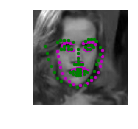

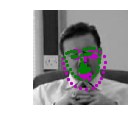

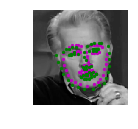

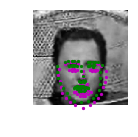

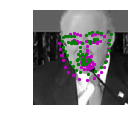

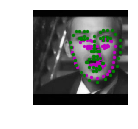

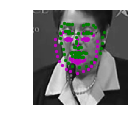

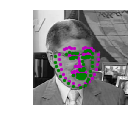

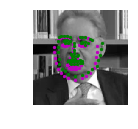

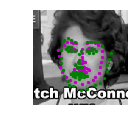

In [16]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:
visualize_output(test_images, test_outputs, gt_pts)

找到了一个或两个表现良好的模型后，保存你的模型，这样你就可以加载它并在以后使用它了！

在这里，你需要保存模型，但请**在提交项目之前删除任何检查点和已保存的模型**，否则你的工作区可能会因为太大而无法提交。

In [18]:
## TODO: change the name to something uniqe for each new model
# Saved in previous cell;
#
# model_dir = 'saved_models/'
# model_name = 'keypoints_model_3_EPOCH-.pt'    # 'keypoints_model_1.pt'
# # after training, save your model parameters in the dir 'saved_models'
# torch.save(net.state_dict(), model_dir+model_name)

完成对一个表现良好的模型的训练后，请回答以下问题，以便我们对你的训练和架构选择过程有一些了解。要通过此项目，你需要回答下列所有问题。

### 问题1：你选择了哪些优化和损失函数？为什么会这样选择？


**答案**: 我选择了PyTorch中的`nn.MESLoss()`作为使用的损失函数, 这是一种常用的损失函数, 使用了`Adam()`优化函数, 这也是一种常用的优化函数, 它会自动根据训练的情况进行步长的调整.

### 问题2：最开始，你的网络架构是什么样的？在尝试不同的架构时，又做了怎样的修改？为避免过度拟合数据，你是否决定添加了更多卷积层或其他层？

**答案**: 最开始我就根据论文中的网络结构使用了4个卷积层, 这避免了单个卷积层的权重过于集中而导致的过拟合, 而后, 在每次Pool之后, 我又添加了Dropout层, 这可以避免过拟合.

### 问题3：你是如何决定训练模型的epoch数量和batch_size的？

**答案**: batch_size主要根据主机的内存来决定(暂未修改), 而epoch, 则根据训练loss的变化, 来调整, 一开始的设置为3, 由于训练时长的关系, 又在第二次训练中改为1.

## 特征可视化

有时，神经网络会被当做是一个黑盒子，给定一些输入，它就会学习产生一些输出。 事实上，CNN正在学习识别各种空间模式，你可以通过查看构成每个卷积核的权重并将这些一次性应用于样本图像来可视化每个卷积层已被训练识别的内容。这种技术称为特征可视化，它对于理解CNN的内部工作方式很有帮助。

在下面的单元格中，你可以看到如何从第一个卷积层中按索引提取单个滤波器。滤波器应显示为灰度网格。

[[-0.08796158 -0.15282255  0.10338074  0.09601919  0.1805042 ]
 [-0.09791116  0.11180297  0.04099893 -0.13982163  0.11003546]
 [-0.01357376  0.04077783 -0.07114782  0.10923268  0.04679602]
 [-0.14574468  0.10770489  0.12470263 -0.22998987 -0.21637955]
 [-0.2219716  -0.03366235  0.08289485 -0.02201975 -0.22431606]]
(5, 5)


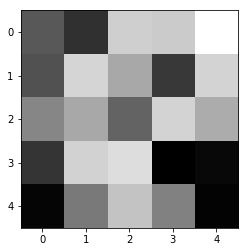

In [17]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data
w = weights1.numpy()
filter_index = 0
print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')

## 特征映射

每个CNN至少包含一个由堆叠滤波器（也称为卷积核）组成的卷积层。CNN在进行训练时，它要学习在卷积内核中包含哪些权重，当这些内核应用于某些输入图像时，它们会产生一组**特征映射**。因此，特征映射只是过滤图像的集合，它们是通过将卷积核应用于输入图像而产生的图像。这些映射向我们展示了神经网络不同层学习提取的特征。例如，你可以想象一个卷积内核，它可以检测到脸部的垂直边缘，而另一个可以检测到眼角的边缘。通过将这些内核应用于图像，你可以看到每个内核检测到了哪些特征。具体请看以下示例，从它在图像中显示线条的方式，你可以将其表征为边缘检测滤波。

<img src='images/feature_map_ex.png' width=50% height=50%/>


接下来，选择一个测试图像并使用已被训练的CNN中的一个卷积内核对其进行过滤。查看过滤后的输出，了解该内核检测到的内容。

### TODO: 过滤图像，查看卷积内核的效果
---

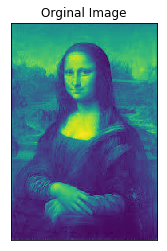

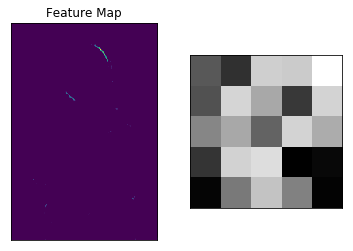

In [29]:
## TODO: load in and display any image from the transformed test dataset
import cv2
# Loading the image
image = cv2.imread('./images/mona_lisa.jpg')
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)    # cv2.COLOR_BGR2RGB
# image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.imshow(image)
plt.xticks([]), plt.yticks([])
plt.title("Orginal Image")

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image;
filtered = cv2.filter2D(image, -1, w[filter_index][0])  # or w[filter_index][0], w[1][0]
fig = plt.figure()
ax  = fig.add_subplot(121, xticks = [], yticks = [])
ax.imshow(filtered)
ax.set_title("Feature Map")
ax  = fig.add_subplot(122, xticks = [], yticks = [])
ax.imshow(w[filter_index][0], cmap = 'gray')  # w[filter_index][0], w[1][0]

plt.show()

### 问题4：从已被训练的CNN中选择一个滤波器并将其应用于测试图像。你认为它会起到什么作用？你认为它会检测到哪种特征？


**答案**: 此处的滤波器的权重分布大致是左上到右下对角线分割的, 从左侧的Feature Map中我们可以印证得到它检测到的轮廓线的方向也是左上到右下的(Mona Lisa的头部轮廓的两小线条).

---
## 继续加油吧！

现在，你已经定义并训练了模型，最终也保存了一个最佳模型。接下来，就是最后一个notebook，它会将人脸检测器与你保存的模型相结合，创建一个人脸关键点检测系统，用于预测一种图像中*任何一个* 人脸的关键点！

In [30]:
import time

In [36]:
# print(time.localtime(time.time()))
print(time.strftime('%Y-%m-%d %H:%M:%S GMT-0',time.localtime(time.time())))

2019-03-31 14:48:53 GMT-0
